# Recapitulate Fig6 Repliseq Z-Score Analysis

In [2]:
setwd("~/Upd-Germline-Genomics")

In [471]:
library(dplyr)
library(GenomicRanges)
library(targets)
source("_targets.R")
tar_load(chic.tile.diameter_1000_chr)
tar_load(matches("repli.timing_.*chr$"))
tar_load(chromosome_pericetromere_label)

Y <- tibble(
  chr = names(chr.lengths),
  xmin = 2500,
  xmax = floor((chr.lengths - 2500) / 5000) * 5000,
  Germline = list(repli.timing_Germline_chr),
  Somatic = list(repli.timing_Somatic_chr),
  Kc167 = list(repli.timing_Kc167_chr),
  S2 = list(repli.timing_S2_chr),
) %>%
  group_by(chr, xmin, xmax) %>%
  reframe(
    x = seq(xmin, xmax, by = 5000),
    region = (
      as.character(chr) %>%
        paste0(
          replace(
            rep("", length(x)),
            chromosome_pericetromere_label %>%
              findOverlaps(
                GRanges(
                  chr,
                  IRanges(x, width=1),
                  seqlengths = seqlengths(repli.timing_Germline_chr)
                )
              ) %>%
              to(),
            "C"
          )
        ) %>%
      factor(
        c("2L", "2LC", "2RC", "2R", "3L", "3LC", "3RC", "3R", "4", "X", "Y", "rDNA")
      )
    ),
    across(
      !matches("^(x|region)$"),
      list(
        LOESS = ~ (
          loess(
            y.track ~ x.track,
            tibble(
              x.track = .x[[1]][seqnames(.x[[1]]) == chr] %>% mid(),
              y.track = .x[[1]][seqnames(.x[[1]]) == chr]$score,
            ),
            span = 0.025
          ) %>%
          predict(tibble(x.track = x))
        )
      )
    )
  ) %>%
  subset(select = -c(xmin, xmax))
YMEAN <- Y %>%
  group_by(region) %>%
  summarise(across(matches("LOESS"), mean))

YS <- Y[
  c("Germline_LOESS", "Somatic_LOESS", "Kc167_LOESS", "S2_LOESS")
] %>%
  as.matrix() %>%
  scale() %>%
  t() %>%
  scale() %>%
  t()
YS[Y$chr == "Y", ] <- (
  YS[Y$chr == "Y", c(1, 2, 4)] %>%
    t() %>%
    scale() %>%
    t() %>%
    `%*%`(
      matrix(
        c(
          1, 0, 0,
          0, 1, 0,
          0, 0, 0,
          0, 0, 1
        ),
        nrow = 3,
        dimnames = list(
          NULL,
          colnames(Y)[4:7]
        )
      )
    )
)

FEATURES <- YS %>%
  apply(
    2,
    \(v) v %>% split(Y$region) %>% sapply(mean)
  )
cor(as.matrix(Y[4:7]))

Loading required package: stats4

Loading required package: BiocGenerics




Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:gridExtra’:

    combine


The following object is masked from ‘package:container’:

    pos


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:container’:

    rename, values


The following objects are maske

,Germline_LOESS,Somatic_LOESS,Kc167_LOESS,S2_LOESS
Germline_LOESS,1.0000000,0.7125756,0.7718862,0.7227317
Somatic_LOESS,0.7125756,1.0000000,0.7703626,0.7373653
Kc167_LOESS,0.7718862,0.7703626,1.0000000,0.8451248
S2_LOESS,0.7227317,0.7373653,0.8451248,1.0000000


# Chop Posterior Distribution

In [5]:
library(targets)
source("_targets.R")

tar_load(matches("repli.posterior_(Germline|Somatic|Kc167|S2)_chr"))
tar_load(repli.prior.distribution)

Loading required package: viridisLite


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [6]:
Angle <- seq(0, pi/2, length.out=length(repli.prior.distribution$X))
Timing <- 1 - 2 * (sin(Angle)/(sin(Angle)+cos(Angle)))
D_Timing_D_Angle <- 1/(1 + sin(2*Angle))
E <- D_Timing_D_Angle %>% replace(!between(Timing, 0.5001, 1), 0)
EM <- D_Timing_D_Angle %>% replace(!between(Timing, 0.0001, 0.5), 0)
ML <- D_Timing_D_Angle %>% replace(!between(Timing, -0.4999, 0), 0)
L <- D_Timing_D_Angle %>% replace(!between(Timing, -1, -0.5), 0)
post <- tibble(
  repli.posterior_Germline_chr["rowname"],
  Germline = repli.posterior_Germline_chr$prob,
  Somatic = repli.posterior_Somatic_chr$prob,
  Kc167 = repli.posterior_Kc167_chr$prob,
  S2 = repli.posterior_S2_chr$prob,
) %>%
  group_by(rowname) %>%
  summarise(
    across(
      everything(),
      list(
        E = \(prob) sum(prob * E) / sum(prob * D_Timing_D_Angle),
        EM = \(prob) sum(prob * EM) / sum(prob * D_Timing_D_Angle),
        ML = \(prob) sum(prob * ML) / sum(prob * D_Timing_D_Angle),
        L = \(prob) sum(prob * L) / sum(prob * D_Timing_D_Angle)
      )
    )
  )
dplyr::slice(post, round(seq(1, nrow(post), length.out=4)))

rowname,Germline_E,Germline_EM,Germline_ML,Germline_L,Somatic_E,Somatic_EM,Somatic_ML,Somatic_L,Kc167_E,Kc167_EM,Kc167_ML,Kc167_L,S2_E,S2_EM,S2_ML,S2_L
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,7.373668e-01,2.531869e-01,0.0092215013,2.247688e-04,0.835031818,0.1649573,1.084879e-05,6.743870e-08,8.646540e-01,1.338143e-01,1.487108e-03,4.458280e-05,6.952317e-01,3.047665e-01,1.877769e-06,8.045190e-12
46498,2.427998e-02,4.777183e-01,0.4979503044,5.138479e-05,0.471201609,0.5126937,1.560406e-02,5.006706e-04,2.612946e-21,1.907546e-10,9.999932e-01,6.816358e-06,2.503634e-05,1.893848e-01,8.105515e-01,3.871422e-05
92994,1.848363e-01,7.399017e-01,0.0752608548,1.141458e-06,0.152858884,0.6218306,2.136067e-01,1.170380e-02,3.711610e-06,9.996132e-01,3.831295e-04,1.408181e-22,1.987119e-01,8.011499e-01,1.382555e-04,1.139095e-11
139491,4.229725e-11,3.217471e-10,0.0004728029,9.995272e-01,0.003228995,0.1827286,6.814172e-01,1.326252e-01,1.950563e-19,1.056359e-17,1.893601e-08,1.000000e+00,3.188143e-10,2.947946e-09,9.961544e-03,9.900385e-01


In [7]:
colnames(post[-1])

[1] "Germline_E"  "Germline_EM" "Germline_ML" "Germline_L"  "Somatic_E"  
 [6] "Somatic_EM"  "Somatic_ML"  "Somatic_L"   "Kc167_E"     "Kc167_EM"   
[11] "Kc167_ML"    "Kc167_L"     "S2_E"        "S2_EM"       "S2_ML"      
[16] "S2_L"

In [8]:
summary(rowSums(as.matrix(post[-1])))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      4       4       4       4       4       4 

In [9]:
args(kmeans)

function (x, centers, iter.max = 10L, nstart = 1L, algorithm = c("Hartigan-Wong", 
    "Lloyd", "Forgy", "MacQueen"), trace = FALSE) 
NULL

# Hierarchical Clustering

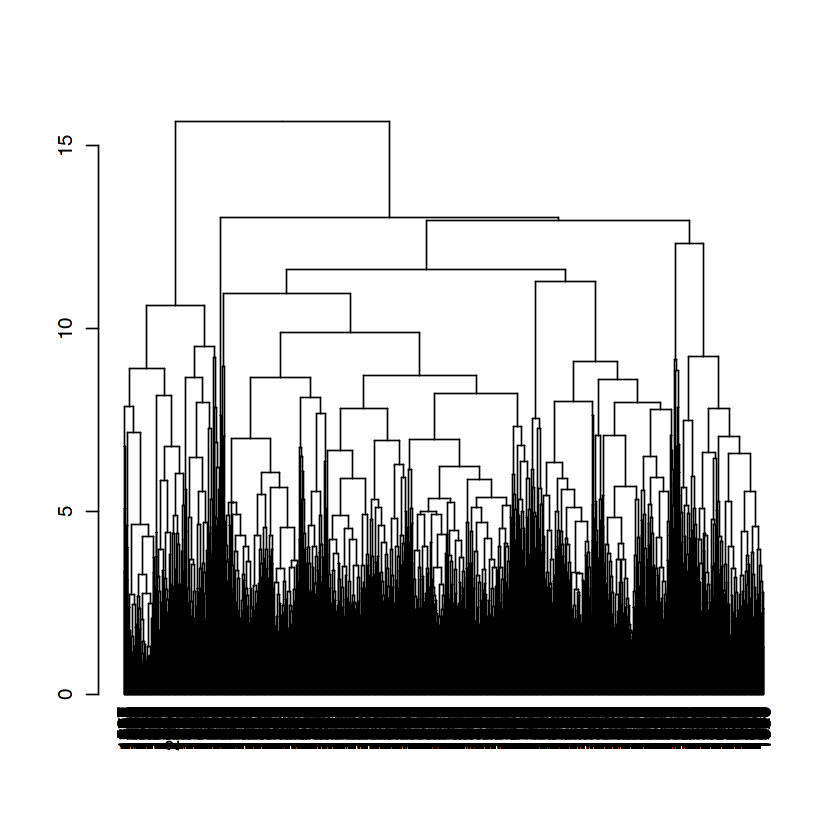

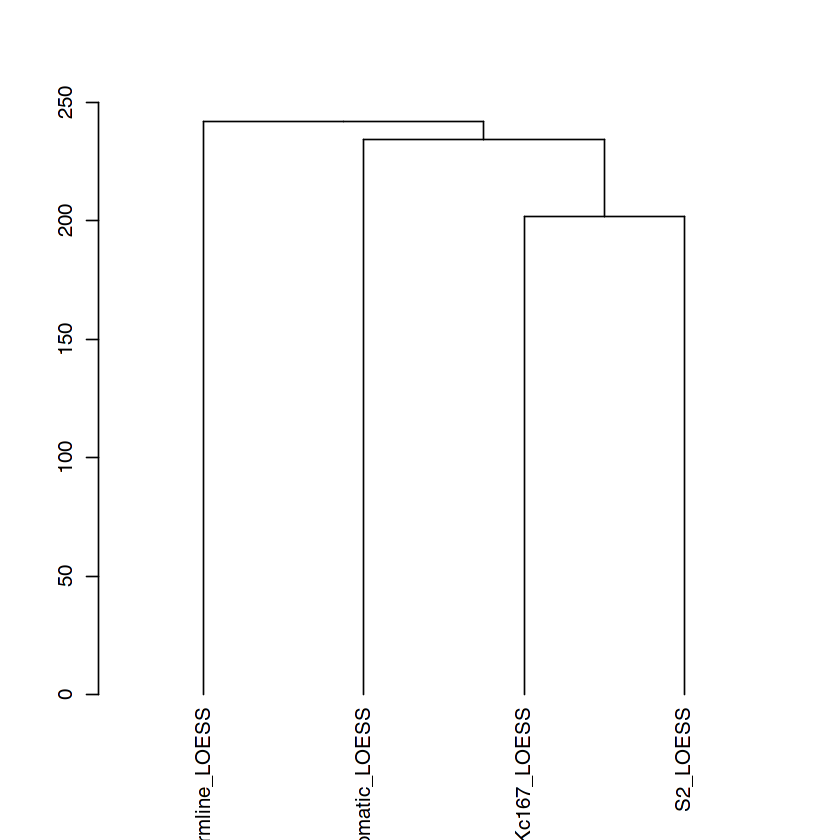

In [ ]:
library(withr)
kmembers <- with_seed(0, kmeans(scale(as.matrix(post[-1])) %*% diag(x = c(3,1,1,3,3,1,1,3,3,1,1,3,3,1,1,3)), 2000, iter.max=100L, nstart=3L))
# cluster <- rank(-kpriority$score, ties.method="first")[kmembers$cluster]
# centers <- kmembers$centers[rank(-kpriority$score, ties.method="first")]
cluster <- kmembers$cluster
centers <- kmembers$centers
Rowv <- as.dendrogram(hclust(dist(centers), "average", members = tabulate(cluster)))
Colv <- as.dendrogram(hclust(dist(t(YS)), "average"))
plot(Rowv)
plot(Colv)

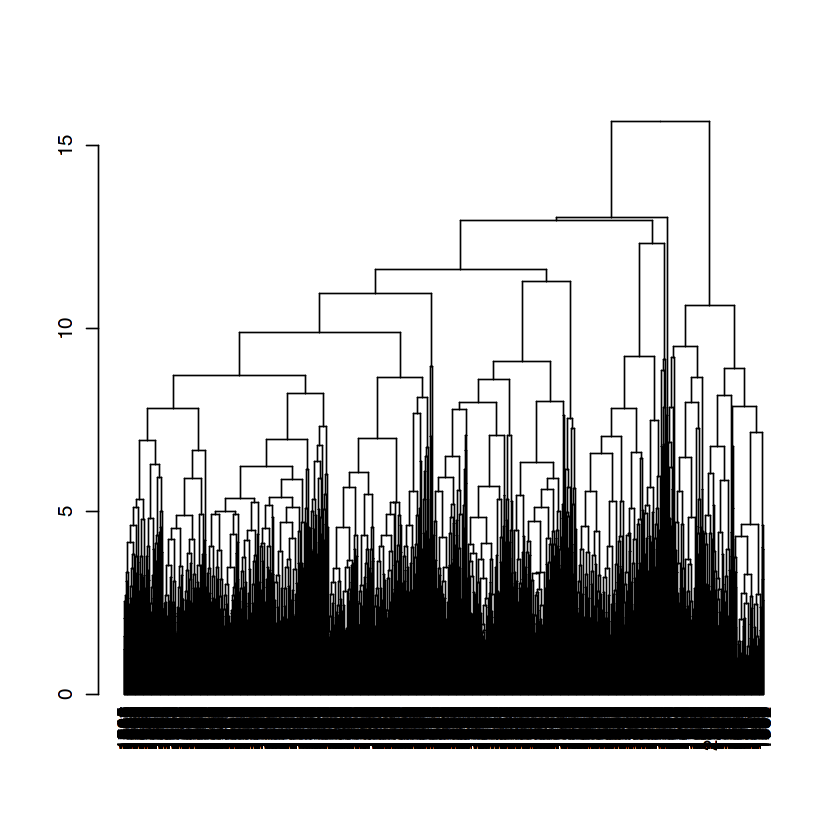

In [110]:
kpriority <- post[-1] %>%
  tibble(cluster = kmembers$cluster, n = tabulate(kmembers$cluster)[kmembers$cluster]) %>%
  group_by(cluster) %>%
  summarise(
    score = median(
      -(
        Germline_E + Somatic_E + Kc167_E + S2_E
      ) /
        (
          Germline_E + Somatic_E + Kc167_E + S2_E +
            Germline_L + Somatic_L + Kc167_L + S2_L
        ) *
        (
          # X drawn uniformly from: {E; EM; ML; L}
          # 16 E[X^2] - 16 (E[X])^2 =
          # 16 (E^2 + EM^2 + ML^2 + L^2) -
          # 16 (E + EM + ML + L)^2 / 16
          15*Germline_E^2 + 15*Germline_EM^2 + 15*Germline_ML^2 + 15*Germline_L^2 -
            2*Germline_E*Germline_EM - 2*Germline_E*Germline_ML - 2*Germline_E*Germline_L -
            2*Germline_EM*Germline_ML - 2*Germline_EM*Germline_L -
            2*Germline_ML*Germline_L +
          15*Somatic_E^2 + 15*Somatic_EM^2 + 15*Somatic_ML^2 + 15*Somatic_L^2 -
            2*Somatic_E*Somatic_EM - 2*Somatic_E*Somatic_ML - 2*Somatic_E*Somatic_L -
            2*Somatic_EM*Somatic_ML - 2*Somatic_EM*Somatic_L -
            2*Somatic_ML*Somatic_L +
          15*Kc167_E^2 + 15*Kc167_EM^2 + 15*Kc167_ML^2 + 15*Kc167_L^2 -
            2*Kc167_E*Kc167_EM - 2*Kc167_E*Kc167_ML - 2*Kc167_E*Kc167_L -
            2*Kc167_EM*Kc167_ML - 2*Kc167_EM*Kc167_L -
            2*Kc167_ML*Kc167_L +
          15*S2_E^2 + 15*S2_EM^2 + 15*S2_ML^2 + 15*S2_L^2 -
            2*S2_E*S2_EM - 2*S2_E*S2_ML - 2*S2_E*S2_L -
            2*S2_EM*S2_ML - 2*S2_EM*S2_L -
            2*S2_ML*S2_L
        )
    )
  )
Rowv <- Rowv %>% reorder(kpriority$score)
plot(Rowv)

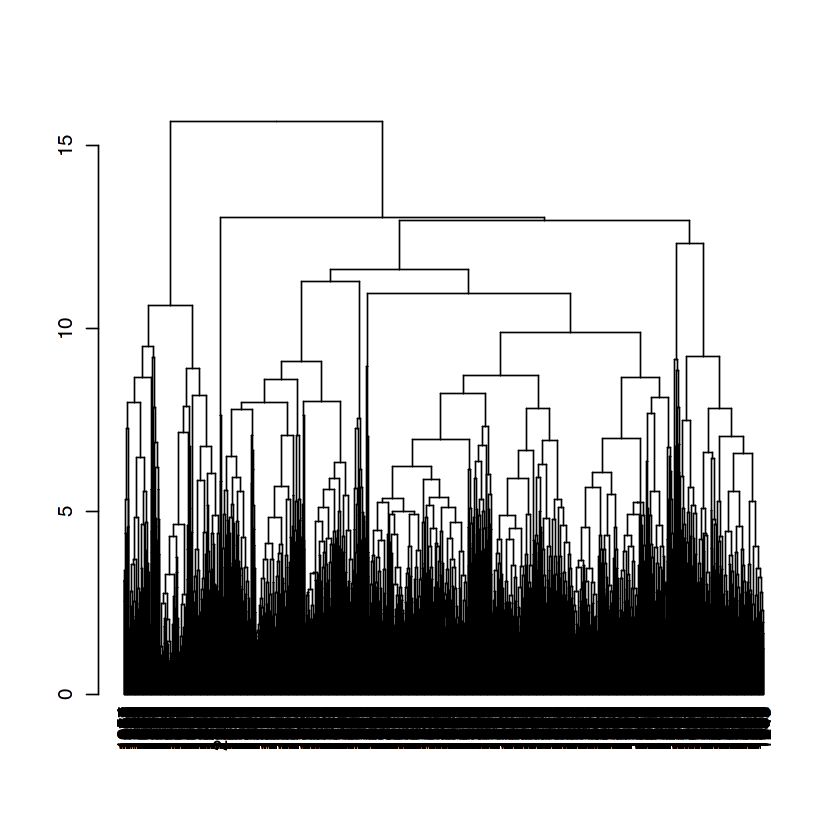

In [122]:
colnames(centers) <- colnames(post)[-1]
kpriority <- centers %>%
  as.data.frame() %>%
  with(
    (
      (
        Somatic_E
      ) /
        (
          Somatic_E +
            Somatic_L
        )
    )
  )
Rowv <- Rowv %>% reorder(kpriority)
saveRDS(Rowv, "illustrations/Fig6Dendrogram.rds")
plot(Rowv)

In [123]:
rowOrder <- sapply(order.dendrogram(Rowv), \(i) which(cluster == i)) %>% do.call(c, .)

In [124]:
library(scales)
repli_palettes <- list(
  pal_seq_gradient("#000000", repli_level_colors$E)(seq(0, 1, length.out=256)),
  pal_seq_gradient("#000000", repli_level_colors$EM)(seq(0, 1, length.out=256)),
  pal_seq_gradient("#000000", repli_level_colors$ML)(seq(0, 1, length.out=256)),
  pal_seq_gradient("#000000", repli_level_colors$L)(seq(0, 1, length.out=256))
)
unit_scale_cuts <- c(-Inf, seq(1/256, 255/256, by=1/256), Inf)
length(unit_scale_cuts)

[1] 257

In [119]:
library(colorspace)
library(OpenImageR)
Image <- tibble(post[1], post[-1][rowOrder, ])
nrow <- 1024
Image <- Image %>%
  mutate(
    level = cut(rowname, seq(0, length(rowname), length.out=nrow+1)),
    .keep = "unused"
  ) %>%
  group_by(level) %>%
  summarise_all(mean)
Image <- mapply(
  \(v, pal) pal[as.numeric(cut(v, unit_scale_cuts))],
  Image[-1],
  repli_palettes
)
Image <- list(
  Image[, c(1, 2,2,3,3, 4,4)] %>%
    hex2RGB() %>%
    `@`(value = "coords") %>%
    array(c(nrow(Image), 7, 3)),
  Image[, c(1, 2,2,3,3, 4,4)+4] %>%
    hex2RGB() %>%
    `@`(value = "coords") %>%
    array(c(nrow(Image), 7, 3)),
  Image[, c(1, 2,2,3,3, 4,4)+8] %>%
    hex2RGB() %>%
    `@`(value = "coords") %>%
    array(c(nrow(Image), 7, 3)),
  Image[, c(1, 2,2,3,3, 4,4)+12] %>%
    hex2RGB() %>%
    `@`(value = "coords") %>%
    array(c(nrow(Image), 7, 3))
)
width <- 64
Image <- Image %>%
  sapply(
    \(M) {
      M <- M * 255
      M2 <- resizeImage(M, nrow, width, method = "bilinear")
      pmin(pmax(M2 / 255, 0), 1)
    },
    simplify = FALSE
  )
Image <- Image %>%
  sapply(
    \(M) M %>%
      matrix(nrow = dim(M)[1] * dim(M)[2]) %>%
      sRGB() %>%
      hex() %>%
      matrix(nrow = nrow),
    simplify=F
  )
dim(Image[[1]])
Image <- do.call(cbind, Image)

[1] 1024   64

In [205]:
library(container)
library(dendextend)
library(ggdendro)

Classification <- Rowv
Classification <- cut(Classification, h=10)$upper %>%
  rank_branches()

In [456]:
library(container)
library(dendextend)
library(ggdendro)

Classification <- Rowv
Classification <- cut(Classification, h=6)$upper %>%
  rank_branches()
xform <- tibble(
  clust = seq(0, 2000),
  x = cumsum(c(0, tabulate(cluster)[order.dendrogram(Rowv)]))
)
segments <- segment(dendro_data(Classification, type = "rectangle"))
segments$x <- approx(
  xform$clust,
  xform$x,
  xout = segments$x
)$y
segments$xend <- approx(
  xform$clust,
  xform$x,
  xout = segments$xend
)$y
ggd <- ggplot(segments) + 
  geom_point(aes(x, y, color = c), data.frame(x=1000, y=1, c="z"), size=0.1) +
  geom_point(aes(x, y), data = data.frame(x=1000, y=1, c="z"), color = "white", size=0.1) +
  geom_segment(aes(x = x, y = y, xend = xend, yend = yend), linewidth = 0.5 * 25.4 / 72) +
  coord_flip(c(0.5, length(rowOrder)+0.5), expand=F) +
  scale_x_continuous(breaks = NULL) +
  scale_y_reverse(breaks = 0, labels = " ") +
  scale_color_hue(guide = guide_legend(NULL, override.aes = list(stroke = NA, size = 0)), labels = "") +
  theme_minimal() +
  theme(
    legend.position = "bottom",
    panel.grid = element_blank(),
  ) +
  labs(x = NULL, y = NULL)

In [394]:
identical(Rowv[[c(1,1,2,2)]], Rowv[[1]][[1]][[2]][[2]])

[1] TRUE

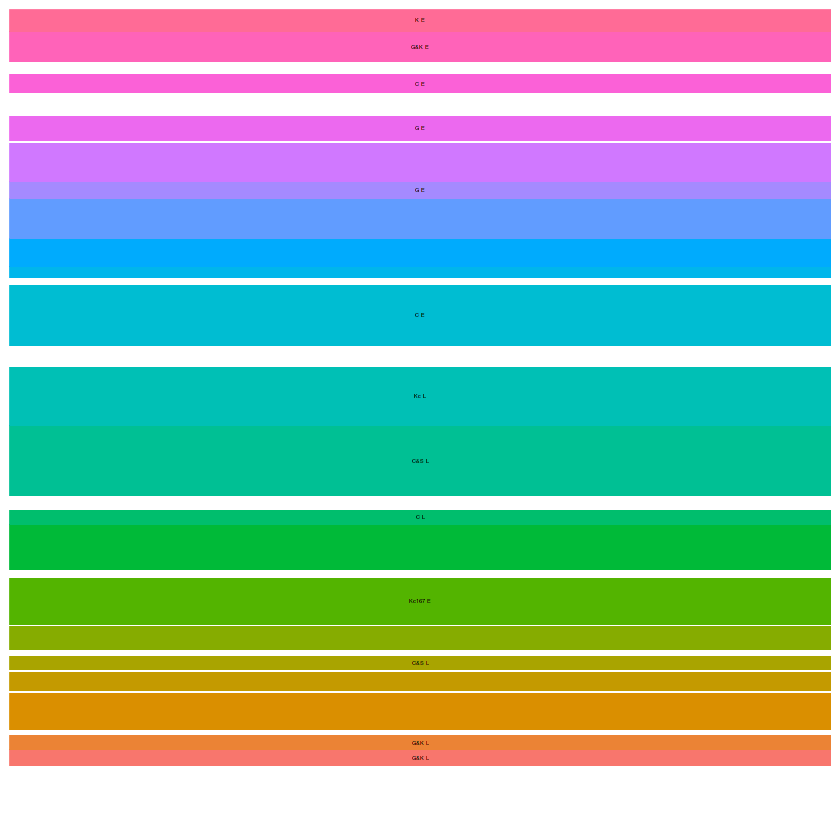

In [468]:
library(collections)

q <- Deque()
q$push(2)
q$push(1)
bands <- numeric(0)
tab <- tabulate(cluster)
while (q$size()) {
  pth <- q$pop()
  if (is.leaf(Classification[[pth]])) {
    bands <- c(bands, sum(tab[as.numeric(labels(Rowv[[pth]]))]))
  } else {
    q$push(c(pth, 2))
    q$push(c(pth, 1))
  }
}

btotal <- cumsum(bands)
rects <- tibble(
  from = c(0, head(btotal, length(btotal) - 1)),
  to = btotal,
) %>%
  subset(to - from >= 2000) %>%
  tibble(
    label = head(LETTERS, length(from)),
    annot = c(
      "G&K L",
      "G&K L",
      "",
      "",
      "C&S L",
      "",
      "Kc167 E",
      "",
      "C L",
      "C&S L",
      "Kc L",
      "C E",
      "",
      "",
      "",
      "G E",
      "",
      "G E",
      "C E",
      "G&K E",
      "K E"
    )
  )
ggdrect <- ggplot(rects, aes(xmin = 0, ymin=from, xmax=1, ymax=to, fill=label)) +
  geom_rect() +
  geom_text(aes(x=0.5, y=(from+to)/2, label=annot), size = 3 * 25.4 / 72) +
  coord_cartesian(expand = F) +
  scale_x_continuous(breaks = NULL) +
  scale_y_continuous(breaks = NULL) +
  scale_fill_hue(
    guide = guide_legend(override.aes = list(fill="transparent"), nrow = 1)
  ) +
  labs(x = NULL, y = NULL) +
  theme_minimal() +
  theme(
    legend.position = "bottom",
    legend.text = element_blank(),
    legend.title = element_blank(),
  )

ggdrect

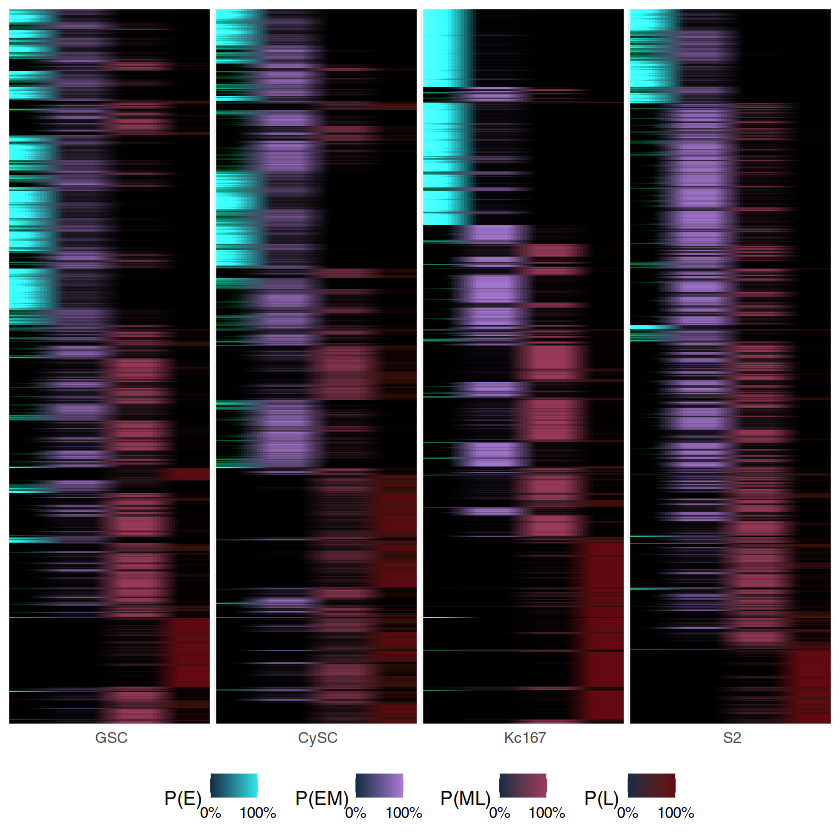

In [436]:
library(ggnewscale)
library(ggplot2)
bh <- 1
bw <- 2
bb <- c(0, 1)
ggplot(
  melt(Image),
  aes(Var2, Var1)
) +
  geom_polygon(aes(fill=E), data = tibble(Var2=1:3, Var1=c(1,3,2), E=2)) +
  scale_fill_gradient("P(E)", high=repli_level_colors$E, limits=c(0,1), breaks=bb, labels=percent, guide=guide_colorbar(order=1, barheight=bh, barwidth=bw)) +
  new_scale_fill() +
  geom_polygon(aes(fill=EM), data = tibble(Var2=1:3, Var1=c(1,3,2), EM=2)) +
  scale_fill_gradient("P(EM)", high=repli_level_colors$EM, limits=c(0,1), breaks=bb, labels=percent, guide=guide_colorbar(order=2, barheight=bh, barwidth=bw)) +
  new_scale_fill() +
  geom_polygon(aes(fill=ML), data = tibble(Var2=1:3, Var1=c(1,3,2), ML=2)) +
  scale_fill_gradient("P(ML)", high=repli_level_colors$ML, limits=c(0,1), breaks=bb, labels=percent, guide=guide_colorbar(order=3, barheight=bh, barwidth=bw)) +
  new_scale_fill() +
  geom_polygon(aes(fill=L), data = tibble(Var2=1:3, Var1=c(1,3,2), L=2)) +
  scale_fill_gradient("P(L)", high=repli_level_colors$L, limits=c(0,1), breaks=bb, labels=percent, guide=guide_colorbar(order=4, barheight=bh, barwidth=bw)) +
  new_scale_fill() +
  geom_raster(aes(fill=value), data = \(data) data %>% subset(between(Var2, 1, 64))) +
  geom_raster(aes(fill=value, Var2+2), data = \(data) data %>% subset(between(Var2, 2^6+1, 0x80))) +
  geom_raster(aes(fill=value, Var2+4), data = \(data) data %>% subset(between(Var2, 0x81, 0xC0))) +
  geom_raster(aes(fill=value, Var2+6), data = \(data) data %>% subset(between(Var2, 0xC1, 0x100))) +
  scale_x_continuous(
    breaks = c(
      0x21, 0x63, 0xA5, 0xE7
    ),
    labels = c(
      "GSC", "CySC", "Kc167", "S2"
    )
  ) +
  scale_y_continuous(breaks = NULL) +
  scale_fill_identity() +
  labs(x = NULL, y = NULL) +
  coord_cartesian(expand = F) +
  theme_minimal() +
  theme(legend.position = "bottom")

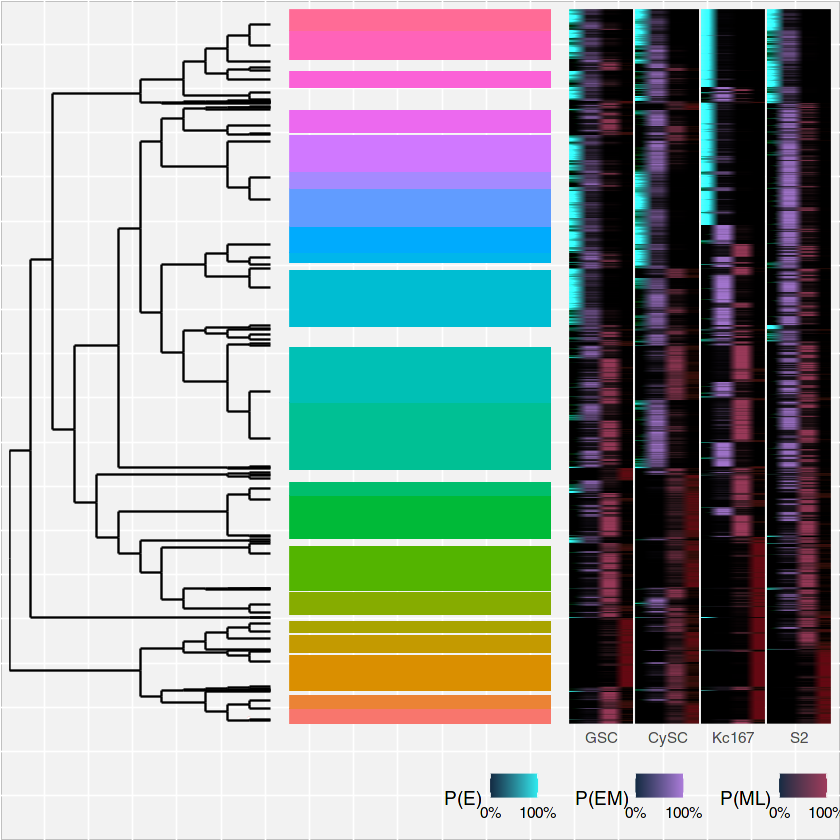

In [437]:
plot(
  cbind(ggplotGrob(ggd), ggplotGrob(ggdrect), ggplotGrob(last_plot()))
)

In [126]:
ggsave("Heatmap.pdf", last_plot() + theme(aspect.ratio = 1), w=6, h=4)
file.size("Heatmap.pdf")/1024/1024

[1] 0.2130728

In [63]:
library(ggdendro)
tree <- dendro_data(Rowv, type="rectangle")
tree


Attaching package: ‘ggdendro’


The following object is masked from ‘package:dendextend’:

    theme_dendro




$segments
              x          y       xend       yend
1     495.66825 15.6724788  161.48241 15.6724788
2     161.48241 15.6724788  161.48241 10.6327515
3     161.48241 10.6327515   71.26584 10.6327515
4      71.26584 10.6327515   71.26584  8.9035829
5      71.26584  8.9035829   16.63177  8.9035829
6      16.63177  8.9035829   16.63177  7.8830670
7      16.63177  7.8830670    2.50000  7.8830670
8       2.50000  7.8830670    2.50000  6.7900980
9       2.50000  6.7900980    1.00000  6.7900980
10      1.00000  6.7900980    1.00000  0.0000000
11      2.50000  6.7900980    4.00000  6.7900980
12      4.00000  6.7900980    4.00000  5.0957059
13      4.00000  5.0957059    2.50000  5.0957059
14      2.50000  5.0957059    2.50000  3.3629677
15      2.50000  3.3629677    2.00000  3.3629677
16      2.00000  3.3629677    2.00000  0.0000000
17      2.50000  3.3629677    3.00000  3.3629677
18      3.00000  3.3629677    3.00000  0.0000000
19      4.00000  5.0957059    5.50000  5.0957059
20      5.

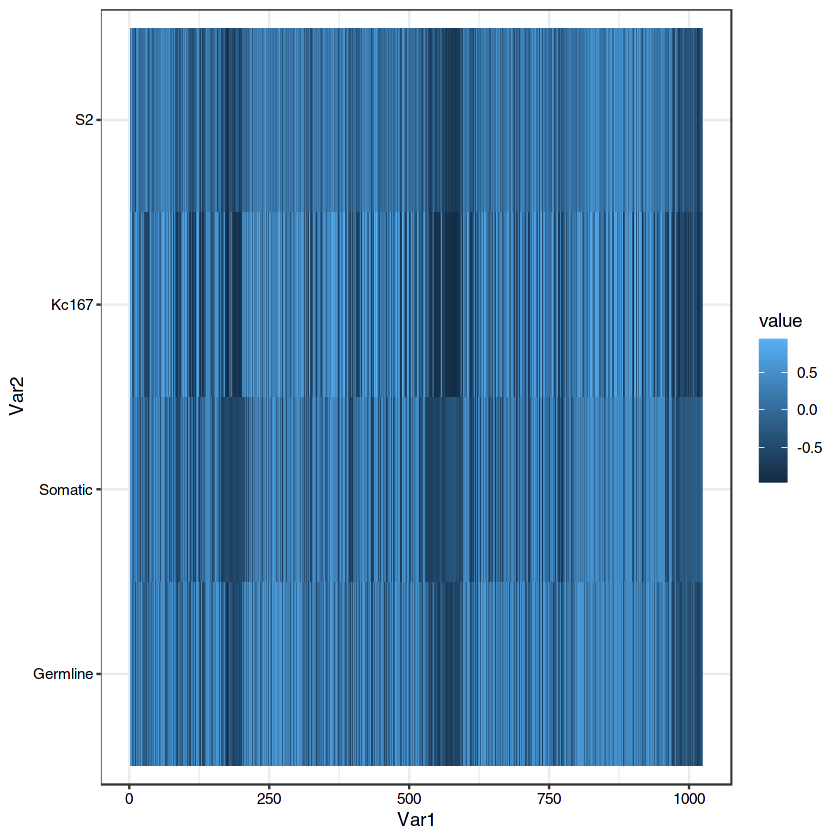

In [287]:
Values <- tibble(
  post[1],
  Germline = repli.timing_Germline_chr$score,
  Somatic = repli.timing_Somatic_chr$score,
  Kc167 = repli.timing_Kc167_chr$score,
  S2 = repli.timing_S2_chr$score,
)
nrow <- 1024
Values <- Values %>%
  mutate(
    level = cut(rowname, seq(0, length(rowname), length.out=nrow+1)),
    .keep = "unused"
  ) %>%
  group_by(level) %>%
  summarise_all(mean)
ggplot(
  melt(as.matrix(Values[-1])),
  aes(Var1, Var2, fill=value)
) +
  geom_raster()

In [101]:
library(colorspace)
library(OpenImageR)
Image <- tibble(post[1], post[-1][rowOrder, ])
nrow <- 1024
Image <- Image %>%
  mutate(
    level = cut(rowname, seq(0, length(rowname), length.out=nrow+1)),
    .keep = "unused"
  ) %>%
  group_by(level) %>%
  summarise_all(mean)
Image <- mapply(
  \(v, pal) pal[as.numeric(cut(v, unit_scale_cuts))],
  Image[-1],
  repli_palettes
)
Image <- list(
  Image[, c(1, 2,2,3,3, 4,4)] %>%
    hex2RGB() %>%
    `@`(value = "coords") %>%
    array(c(nrow(Image), 7, 3)),
  Image[, c(1, 2,2,3,3, 4,4)+4] %>%
    hex2RGB() %>%
    `@`(value = "coords") %>%
    array(c(nrow(Image), 7, 3)),
  Image[, c(1, 2,2,3,3, 4,4)+8] %>%
    hex2RGB() %>%
    `@`(value = "coords") %>%
    array(c(nrow(Image), 7, 3)),
  Image[, c(1, 2,2,3,3, 4,4)+12] %>%
    hex2RGB() %>%
    `@`(value = "coords") %>%
    array(c(nrow(Image), 7, 3))
)
width <- 64
Image <- Image %>%
  sapply(
    \(M) {
      M <- M * 255
      M2 <- resizeImage(M, nrow, width, method = "bilinear")
      pmin(pmax(M2 / 255, 0), 1)
    },
    simplify = FALSE
  )
Image <- Image %>%
  sapply(
    \(M) M %>%
      matrix(nrow = dim(M)[1] * dim(M)[2]) %>%
      sRGB() %>%
      hex() %>%
      matrix(nrow = nrow),
    simplify=F
  )
dim(Image[[1]])
Image <- do.call(cbind, Image)

[1] 1024   64

In [102]:
repli_bar <- array(
  rep(
    unlist(repli_level_colors, use.names=F),
    c(1, 2, 2, 2)
  ) %>%
    rep(10) %>%
    hex2RGB() %>%
    `@`(value = "coords"),
  dim = c(7, 10, 3)
)
repli_bar <- repli_bar %>%
  resizeImage(
    w = 64, h = 10, "bilinear"
  )
repli_bar <- repli_bar[, 5, ] %>%
  pmax(0) %>%
  pmin(255) %>%
  `/`(255) %>%
  sRGB() %>%
  hex()
repli_bar

[1] "#00FFFF" "#00FFFF" "#00FFFF" "#00FFFC" "#00FFFA" "#04FFF8" "#12FFF5"
 [8] "#1FF9F3" "#2DEDF0" "#3BE1EE" "#48D4EC" "#56C8E9" "#64BCE7" "#71B0E4"
[15] "#7FA4E2" "#8D98E0" "#9A8CDD" "#A87FDB" "#AC7CDA" "#AC7CDA" "#AC7CDA"
[22] "#AC7CDA" "#AC7CDA" "#AC7CDA" "#AC7CDA" "#AC7CDA" "#AC7CDA" "#AB78D2"
[29] "#AA71C4" "#A86AB7" "#A763A9" "#A65C9B" "#A4548D" "#A34D7F" "#A14672"
[36] "#A03F64" "#9F3B5C" "#9F3B5C" "#9F3B5C" "#9F3B5C" "#9F3B5C" "#9F3B5C"
[43] "#9F3B5C" "#9F3B5C" "#9F3B5C" "#9D395A" "#973452" "#912E4A" "#8A2941"
[50] "#842339" "#7D1E31" "#771829" "#711221" "#6A0D19" "#650812" "#650812"
[57] "#650812" "#650812" "#650812" "#650812" "#650812" "#650812" "#650812"
[64] "#650812"

In [103]:
nrow <- 1024
level <- cut(order(rowOrder), seq(0, length(rowOrder), length.out=nrow+1))
Post_Band <- tibble(
  GSC = tibble(
    level = rep(as.numeric(level), each = length(repli.prior.distribution$X)),
    repli.posterior_Germline_chr
  ) %>%
    group_by(level) %>%
    reframe(
      index = seq_along(repli.prior.distribution$X),
      prob = matrix(prob, nrow=length(repli.prior.distribution$X)) %>%
        `/`(rep(colSums(. / D_Timing_D_Angle), each = length(repli.prior.distribution$X))) %>%
        rowMeans()
    ) %>%
      acast(level ~ index),
  CySC = tibble(
    level = rep(as.numeric(level), each = length(repli.prior.distribution$X)),
    repli.posterior_Somatic_chr
  ) %>%
    group_by(level) %>%
    reframe(
      index = seq_along(repli.prior.distribution$X),
      prob = matrix(prob, nrow=length(repli.prior.distribution$X)) %>%
        `/`(rep(colSums(. / D_Timing_D_Angle), each = length(repli.prior.distribution$X))) %>%
        rowMeans()
    ) %>%
      acast(level ~ index),
  Kc167 = tibble(
    level = rep(as.numeric(level), each = length(repli.prior.distribution$X)),
    repli.posterior_Kc167_chr
  ) %>%
    group_by(level) %>%
    reframe(
      index = seq_along(repli.prior.distribution$X),
      prob = matrix(prob, nrow=length(repli.prior.distribution$X)) %>%
        `/`(rep(colSums(. / D_Timing_D_Angle), each = length(repli.prior.distribution$X))) %>%
        rowMeans()
    ) %>%
      acast(level ~ index),
  S2 = tibble(
    level = rep(as.numeric(level), each = length(repli.prior.distribution$X)),
    repli.posterior_S2_chr
  ) %>%
    group_by(level) %>%
    reframe(
      index = seq_along(repli.prior.distribution$X),
      prob = matrix(prob, nrow=length(repli.prior.distribution$X)) %>%
        `/`(rep(colSums(. / D_Timing_D_Angle), each = length(repli.prior.distribution$X))) %>%
        rowMeans()
    ) %>%
      acast(level ~ index),
)


Using prob as value column: use value.var to override.

Using prob as value column: use value.var to override.

Using prob as value column: use value.var to override.

Using prob as value column: use value.var to override.



In [104]:
Post_Band$GSC[800,, drop=T]

1            2            3            4            5            6 
5.669764e-05 5.925199e-05 6.206534e-05 6.517087e-05 6.860739e-05 7.242052e-05 
           7            8            9           10           11           12 
7.666420e-05 8.140248e-05 8.671194e-05 9.268469e-05 9.943221e-05 1.070904e-04 
          13           14           15           16           17           18 
1.158262e-04 1.258461e-04 1.374081e-04 1.508367e-04 1.665446e-04 1.850610e-04 
          19           20           21           22           23           24 
2.070721e-04 2.334763e-04 2.654627e-04 3.046216e-04 3.531022e-04 4.138374e-04 
          25           26           27           28           29           30 
4.908648e-04 5.897838e-04 7.183985e-04 8.876060e-04 1.112590e-03 1.414342e-03 
          31           32           33           34           35           36 
1.821465e-03 2.372019e-03 3.114904e-03 4.109850e-03 5.424687e-03 7.128401e-03 
          37           38           39           40           41           42 
9.278897e-03 1.190567e-02 1.498966e-02 1.844486e-02 2.210811e-02 2.574430e-02 
          43           44           45           46           47           48 
2.907265e-02 3.181268e-02 3.373507e-02 3.469435e-02 3.463305e-02 3.357670e-02 
          49           50           51           52           53           54 
3.164360e-02 2.905309e-02 2.608202e-02 2.295954e-02 1.977921e-02 1.653151e-02 
          55           56           57           58           59           60 
1.324581e-02 1.008974e-02 7.309399e-03 5.083073e-03 3.442431e-03 2.304239e-03 
          61           62           63           64           65           66 
1.543489e-03 1.044402e-03 7.185737e-04 5.047014e-04 3.624659e-04 2.661253e-04 
          67           68           69           70           71           72 
1.994746e-04 1.523297e-04 1.182430e-04 9.307643e-05 7.412865e-05 5.960322e-05 
          73           74           75 
4.828262e-05 3.932626e-05 3.214335e-05

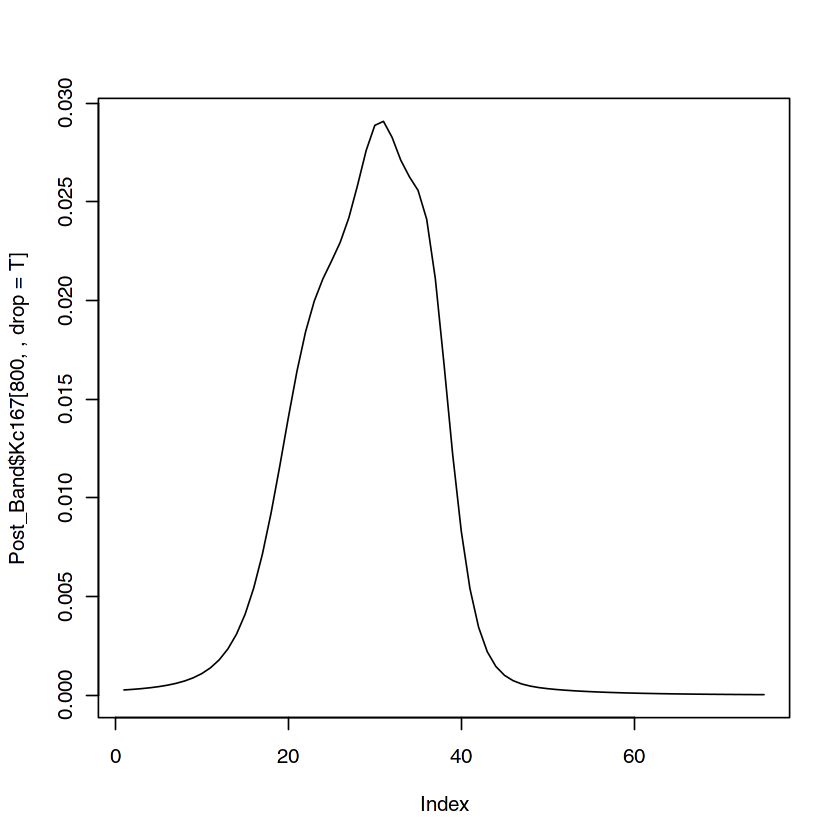

In [105]:
plot(Post_Band$Kc167[800,, drop=T], type='l')

In [106]:
Image <- apply(
  Post_Band$GSC,
  1,
  \(v) approx(rev(Timing), rev(v), xout=seq(-63/64, 63/64, by=1/32))$y %>%
    `/`(max(.))
) %>%
  t()
dim(Image)

[1] 1024   64

In [438]:
Image <- Post_Band %>%
  sapply(
    \(img) mixcolor(
      apply(
        img,
        1,
      \(v) approx(rev(Timing), rev(v), xout=seq(63/64, -63/64, by=-1/32))$y %>%
          `/`(max(.))
      ) %>%
        t(),
      hex2RGB("#000000"),
      matrix(
        rep(repli_bar, nrow),
        nrow=nrow,
        byrow=TRUE
      ) %>%
        hex2RGB()
    ) %>%
      hex() %>%
      matrix(nrow=nrow),
    simplify=FALSE
  )

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


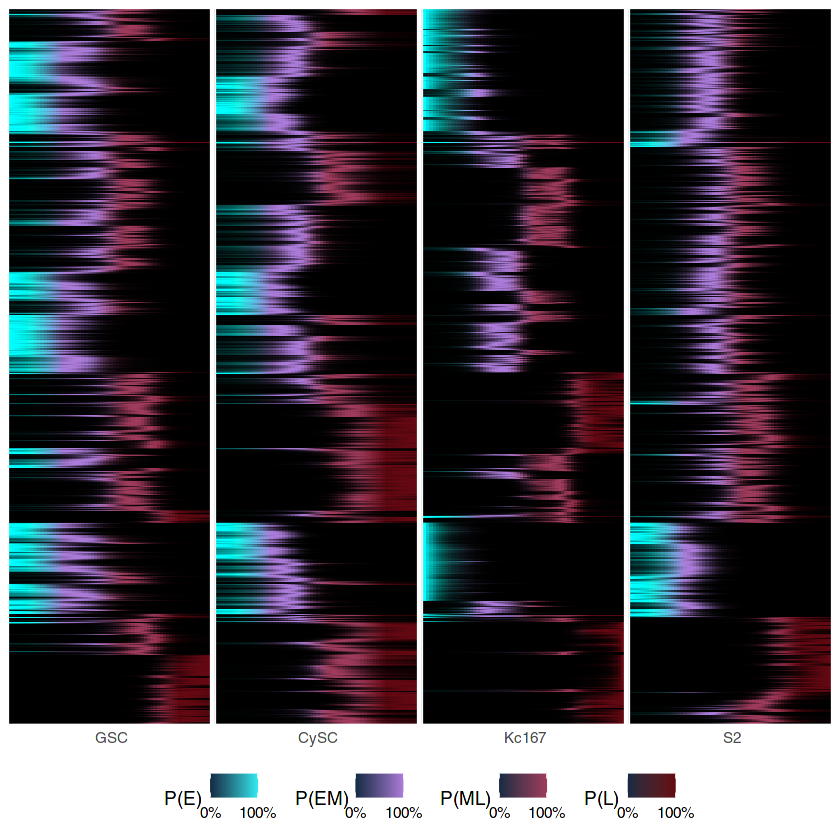

In [451]:
library(ggnewscale)
library(ggplot2)

gg <- ggplot(
  data.frame(),
  aes(Var2, Var1)
) +
  geom_polygon(aes(fill=E), data = tibble(Var2=1:3, Var1=c(1,3,2), E=2)) +
  scale_fill_gradient("P(E)", high=repli_level_colors$E, limits=c(0,1), breaks=bb, labels=percent, guide=guide_colorbar(order=1, barheight=bh, barwidth=bw)) +
  new_scale_fill() +
  geom_polygon(aes(fill=EM), data = tibble(Var2=1:3, Var1=c(1,3,2), EM=2)) +
  scale_fill_gradient("P(EM)", high=repli_level_colors$EM, limits=c(0,1), breaks=bb, labels=percent, guide=guide_colorbar(order=2, barheight=bh, barwidth=bw)) +
  new_scale_fill() +
  geom_polygon(aes(fill=ML), data = tibble(Var2=1:3, Var1=c(1,3,2), ML=2)) +
  scale_fill_gradient("P(ML)", high=repli_level_colors$ML, limits=c(0,1), breaks=bb, labels=percent, guide=guide_colorbar(order=3, barheight=bh, barwidth=bw)) +
  new_scale_fill() +
  geom_polygon(aes(fill=L), data = tibble(Var2=1:3, Var1=c(1,3,2), L=2)) +
  scale_fill_gradient("P(L)", high=repli_level_colors$L, limits=c(0,1), breaks=bb, labels=percent, guide=guide_colorbar(order=4, barheight=bh, barwidth=bw)) +
  new_scale_fill() +
  geom_polygon(data = tibble(Var2=1:3, Var1=c(1,3,2), L=2), fill = "white") +

  geom_raster(aes(fill = value), melt(Image$GSC)) +
  geom_raster(aes(Var2 + 0x42, fill = value), data = melt(Image$CySC)) +
  geom_raster(aes(Var2 + 0x84, fill = value), data = melt(Image$Kc167)) +
  geom_raster(aes(Var2 + 0xC6, fill = value), data = melt(Image$S2)) +
  scale_fill_identity() +
  scale_x_continuous(
    breaks = c(
      0x21, 0x63, 0xA5, 0xE7
    ),
    labels = c(
      "GSC", "CySC", "Kc167", "S2"
    )
  ) +
  scale_y_continuous(breaks = NULL) +
  scale_fill_identity() +
  labs(x = NULL, y = NULL) +
  coord_cartesian(expand = F) +
  theme_minimal() +
  theme(legend.position = "bottom")
gg

In [477]:
attributes(Colv[[1]])

$members
[1] 1

$height
[1] 0

$label
[1] "Germline_LOESS"

$leaf
[1] TRUE

$class
[1] "dendrogram"

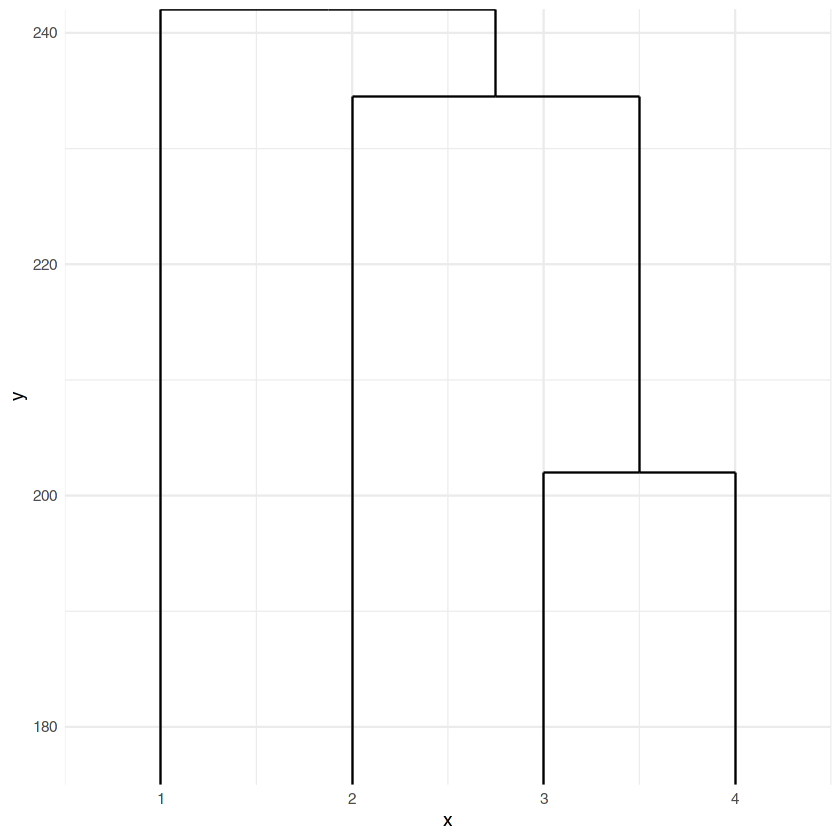

In [486]:
ColPlot <- Colv
i <- 1
ColPlot[[i]] <- ColPlot[[i]] %>% `attr<-`("height", value = 175)
i <- c(2, 1)
ColPlot[[i]] <- ColPlot[[i]] %>% `attr<-`("height", value = 175)
i <- c(2, 2, 1)
ColPlot[[i]] <- ColPlot[[i]] %>% `attr<-`("height", value = 175)
i <- c(2, 2, 2)
ColPlot[[i]] <- ColPlot[[i]] %>% `attr<-`("height", value = 175)
Y_Margin <- segment(dendro_data(ColPlot, type = "rectangle")) %>%
  ggplot(aes(x, y, xend = xend, yend = yend)) +
  geom_segment() +
  coord_cartesian(c(0.5, 4.5), NULL, ex=F) +
  theme_void()
Y_Margin + theme_minimal()

In [503]:
library(egg)
library(grid)
library(gtable)
pdf("illustrations/Fig6Dendrogram.pdf", w=7.5, h=5)
grob <- cbind(
  set_panel_size(
    ggd + theme(plot.margin = margin(30, , 5.5, 5.5)),
    w = unit(0.5, "in"), h = unit(3, "in")
  ),
  set_panel_size(
    ggdrect + theme(plot.margin = margin(, , 5.5, )),
    w = unit(1, "in")
  ),
  set_panel_size(gg + theme(plot.margin = margin(5.5, , 5.5, 2)), w = unit(3, "in"))
) %>%
  gtable_add_grob(
    ggplotGrob(Y_Margin),
    t = 1,
    l = 23
  )
grid.draw(grob)
dev.off()
file.size("illustrations/Fig6Dendrogram.pdf")

png 
  2

[1] 307054